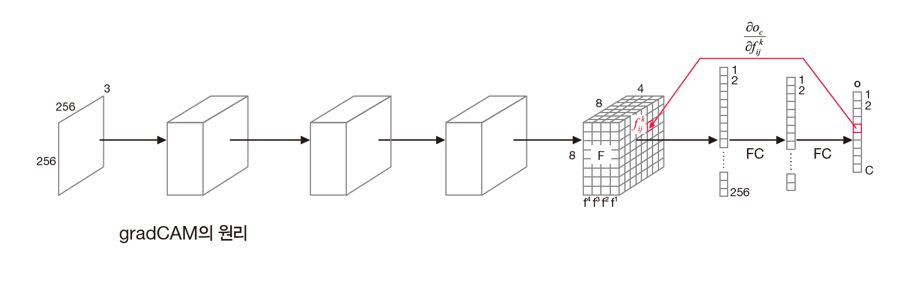

In [1]:
# GradCAM - Lin이 제안한 전역 평균 폴링 GAP(Global Average Pooling)
#  - 컨볼류션을 이용한 신경망의 구조를 획기적으로 줄여줄수 있는 알고리즘
# 가중치가 2만개 이상인 컨볼류션 신경망을 40개정도의 가중치가 있는 구조로 변경
# CAM은 혁신적인 아이디어지만.. 한계
# 전역 폴링에 의존, 전역 평균폴링을 사용하지 않는 모델에는 적용 불가   
# K번째 특징 맵의 그레디언트에 전역평균 폴링을 적용하는 것과 동일
from IPython.display import Image
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/88.PNG", width=500)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
# 이미지를 기반으로한 신경망 모델을 불러온다.. 이미 만들어져 있음
model =  ResNet50(weights='imagenet')

In [4]:
model.summary() # ResNet50 모델 구조

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

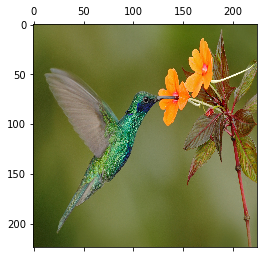

In [5]:
image_path = './hummingbird.jpg'
img = image.load_img(image_path,target_size=(224,224))
plt.matshow(img)

In [6]:
# 영상을 신경망 입력형태로 변환
x =  image.img_to_array(img)
x.shape

(224, 224, 3)

In [7]:
x = np.expand_dims(x, axis=0)
x.shape

(1, 224, 224, 3)

In [8]:
x = resnet50.preprocess_input(x)

In [9]:
preds =  model.predict(x)
print("예측결과:",resnet50.decode_predictions(preds,top=5)[0])

예측결과: [('n01833805', 'hummingbird', 0.99983835), ('n01843065', 'jacamar', 0.00010588149), ('n02280649', 'cabbage_butterfly', 1.0400287e-05), ('n01806143', 'peacock', 8.702703e-06), ('n02190166', 'fly', 4.189647e-06)]


In [10]:
# 신경망 모델의 특징 추출(컨볼류션층) 부분에서 마지막 층을 지정
# 특징 추출 부분만으로 구성된 모델 model_1 을 생성

In [11]:
last_conv_layer =  model.get_layer("conv5_block3_out")

In [12]:
model_1 = keras.Model(model.inputs,last_conv_layer.output)

In [13]:
# 분류(전역평균폴링 또는 안전연결층) 부분만으로 구성된 model_2 만들기
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = model.get_layer("avg_pool")(input_2)
x_2 = model.get_layer("predictions")(x_2)
model_2 = keras.Model(input_2,x_2)

In [14]:
with tf.GradientTape() as tape:
    output_1 = model_1(x)
    tape.watch(output_1)
    preds = model_2(output_1)
    class_id = tf.argmax(preds[0])
    output_2 = preds[:,class_id]    

In [15]:
# 그레디언트 계산
grads = tape.gradient(output_2, output_1)
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2))

In [16]:
output_1 =  output_1.numpy()[0]
pooled_grads =  pooled_grads.numpy()

In [17]:
# GradCAm 적용
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i] *= pooled_grads[i]    
heatmap = np.mean(output_1,axis=-1)    

In [18]:
temp = np.asarray([[10,20,30,40,50],[20,50,40,30,10]])
np.maximum(temp,20)

array([[20, 20, 30, 40, 50],
       [20, 50, 40, 30, 20]])

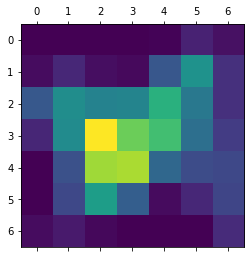

In [19]:
# 0, 1 정규화
heatmap =  np.maximum(heatmap,0)/np.max(heatmap) # 음수는 0으로 변경후 정규화 함
plt.matshow(heatmap)

In [20]:
# 열지도를 입력영상에 덧씌우는 작업
img = image.load_img(image_path)
img = image.img_to_array(img)
heatmap = np.uint8(255*heatmap)  # 0 ~ 255 로 변환

In [25]:
jet = cm.get_cmap('jet') # [0,255] 열지도를 jet 컬러맵으로 표시
color = jet(np.arange(256))[:,:3]
color_heatmap  = color[heatmap]

In [22]:
color_heatmap =  keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize((img.shape[1],img.shape[0]))
color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)

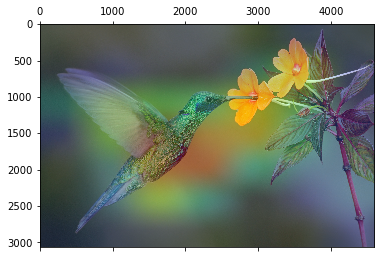

In [23]:
overlay_img = color_heatmap*0.4+img  # 덧씌움
overlay_img = keras.preprocessing.image.array_to_img(overlay_img)
plt.matshow(overlay_img)

In [27]:
# Xception 모델에 GradCam을 적용
from tensorflow.keras.applications import xception
# 사전에 학습된 신경망 모델을 불러오고 신경망 구조를확인
model = xception.Xception(weights='imagenet')
model.summary()

91897856/91884032 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [28]:
image_path

'./hummingbird.jpg'

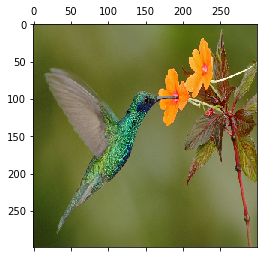

In [29]:
img = image.load_img(image_path,target_size=(299,299))
plt.matshow(img)

In [30]:
# 영상을 신경망 입력 형태로 변환
x = image.img_to_array(img)
x=np.expand_dims(x,axis=0)
x=xception.preprocess_input(x)

In [32]:
# 인식을 시도하고 top-5 결과를 출력
preds =  model.predict(x)
print(f"예측결과 : {xception.decode_predictions(preds,top=5)[0]}")

예측결과 : [('n01833805', 'hummingbird', 0.96300226), ('n01843065', 'jacamar', 0.002827944), ('n01687978', 'agama', 0.0006937465), ('n01682714', 'American_chameleon', 0.0005894135), ('n02268443', 'dragonfly', 0.00047723175)]


In [34]:
last_conv_layer = model.get_layer("block14_sepconv2_act")
model_1 = keras.Model(model.inputs,last_conv_layer.output)
# 분류(전역평균 폴링 또는 완전연결 층) 부분만으로 구성된 모델 model_2
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = model.get_layer("avg_pool")(input_2)
x_2 = model.get_layer("predictions")(x_2)
model_2 = keras.Model(input_2,x_2)


In [ ]:
# 나머지는 ResNet50에 적용한 코드를 그대로 사용할 것....